In [1]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from method_utils import load_dataset
from method_utils import get_generators
from method_utils import get_distances
from method_utils import get_gramian
from method_utils import normalize_distances

from scipy.linalg import expm

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

### Load dataset

In [80]:
# Set location to 'temporal_networks' or 'datasets' depending on the location of the dataset
dataset_name = 'syn_210_100'
location = 'datasets'

vertices, edges, adj_matrices, labels = load_dataset(dataset_name, loc=location)

In [81]:
L = get_generators(adj_matrices)

### Plot 10 largest eigenvalues of generators $L_{\alpha}$.

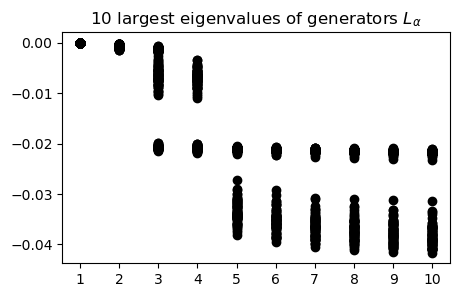

In [82]:
plt.figure(figsize=(5,3))
plt.title("10 largest eigenvalues of generators $L_{\\alpha}$")
x_axis = np.arange(1,11)
plt.xticks(x_axis)

for n in range(len(L)):
    L_eigvals, L_eigvecs = np.linalg.eig(L[n])
    L_eigvals_sorted = np.sort(L_eigvals)[-10:][::-1]
    plt.scatter(x=x_axis, y=L_eigvals_sorted, c='black')

In [83]:
tau = 50
sigma = 0.5

### Compute $P_{\alpha}^{\tau}$ for all snapshots $0\leq\alpha\leq M-1$.

In [84]:
P_tau = np.array([expm(L[n]*tau) for n in range(len(L))])

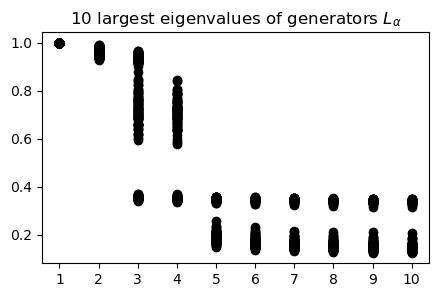

In [85]:
plt.figure(figsize=(5,3))
plt.title("10 largest eigenvalues of generators $L_{\\alpha}$")
x_axis = np.arange(1,11)
plt.xticks(x_axis)

for n in range(len(L)):
    P_eigvals, P_eigvecs = np.linalg.eig(P_tau[n])
    P_eigvals_sorted = np.sort(P_eigvals)[-10:][::-1]
    plt.scatter(x=x_axis, y=P_eigvals_sorted, c='black')

### Compute matrix $K$

In [86]:
distances = get_distances(P_tau)

Computing distances: 100%|##########| 210/210 [00:00<00:00, 245.25it/s]


In [87]:
K = get_gramian(distances, sigma)
np.fill_diagonal(K, 0)

### Compute temporal generator $L_{temp}$.

In [88]:
L_temp = get_generators(K)

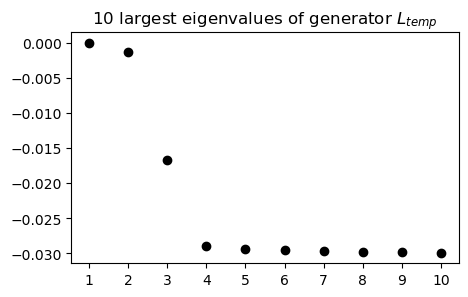

In [89]:
plt.figure(figsize=(5,3))
plt.title("10 largest eigenvalues of generator $L_{temp}$")
x_axis = np.arange(1,11)
plt.xticks(x_axis)

L_temp_eigvals, L_temp_eigvecs = np.linalg.eig(L_temp)
L_temp_eigvals_sorted = np.sort(L_temp_eigvals)[-10:][::-1]
plt.scatter(x=x_axis, y=L_temp_eigvals_sorted, c='black')

### Set $\tau_{temp}$ and compute $P_{temp}^{\tau_{temp}}$

In [101]:
tau_temp = 50
P_temp = expm(L_temp*tau_temp)

Text(0.5, 1.0, 'Transition matrix $P_{temp}^{\\tau_{temp}}$')

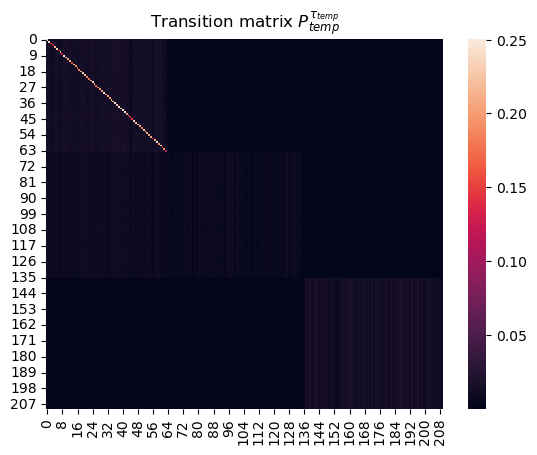

In [102]:
ax = sn.heatmap(P_temp)
ax.set_title("Transition matrix $P_{temp}^{\\tau_{temp}}$")

### Spectral clustering of $P^{\tau_{temp}}_{temp}$.

Determine dominant eigenvalues of transition matrix $P^{\tau}_{temp}$

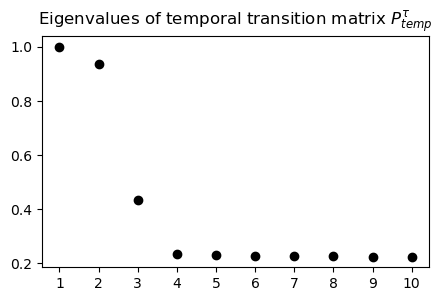

In [103]:
P_temp_eigval, P_temp_eigvec = np.linalg.eig(P_temp)
indices = np.argsort(P_temp_eigval)[-10:][::-1]
P_temp_eigval_sorted = P_temp_eigval[indices]
P_temp_eigvec_sorted = P_temp_eigvec[:, indices]

plt.figure(figsize=(5, 3))
plt.title("Eigenvalues of temporal transition matrix $P_{temp}^{\\tau}$")
plt.xticks(np.arange(1,11))
plt.scatter(np.arange(1, 11), P_temp_eigval_sorted, c='black')

Get snapshot embeddings

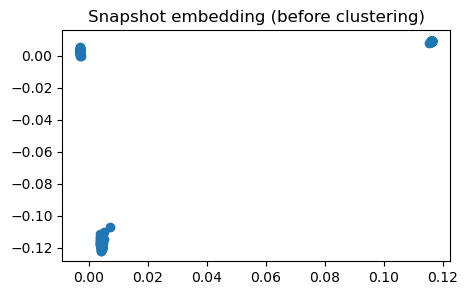

In [104]:
dominant_eigenvalues = 2

data = P_temp_eigvec_sorted[:, :dominant_eigenvalues]

plot_coordinates = P_temp_eigvec_sorted[:, 1:3]
plt.figure(figsize=(5,3))
plt.title("Snapshot embedding (before clustering)")
plt.scatter(plot_coordinates[:,0], plot_coordinates[:,1])


Perform spectral clustering

In [105]:
kmeans = KMeans(n_clusters=dominant_eigenvalues, random_state=0)
kmeans.fit(np.real(data))

predicted_labels = kmeans.labels_
print(predicted_labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/home/filip/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Compute ARI score

In [98]:
ari = adjusted_rand_score(labels, predicted_labels)
print(f"ARI: {ari*100}")

ARI: 100.0


### Get Distance matrix (LNE)

Text(0.5, 1.0, 'Distance matrix of syn_15_120 dataset; $\\tau=100$, $\\sigma=0.5$, $\\tau_{temp}=0.5$')

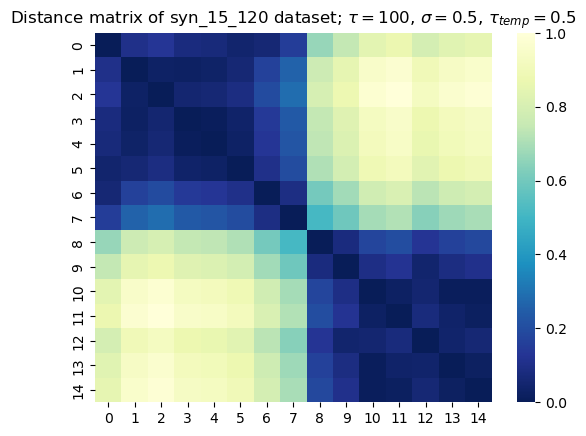

In [78]:
distance_matrix = np.zeros(shape=(len(adj_matrices), len(adj_matrices)))

for i in range(len(adj_matrices)):
    for j in range(len(adj_matrices)):
        distance_matrix[i, j] = np.linalg.norm(data[i,:] - data[j,:])

distance_matrix_norm, min_distance, max_distance = normalize_distances(distance_matrix)

ax = sn.heatmap(distance_matrix_norm, annot=False, annot_kws={"size": 16}, cmap="YlGnBu_r")
ax.set_title(f"Distance matrix of {dataset_name} dataset; $\\tau={tau}$, $\sigma={sigma}$, $\\tau_{{temp}}={tau_temp}$")

### Snapshot embedding (clustered)

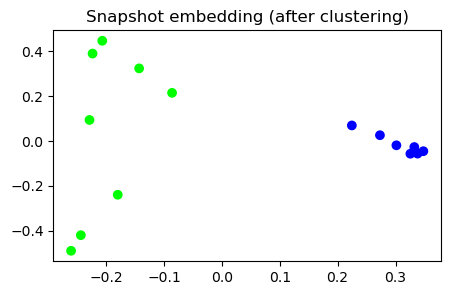

In [79]:
plot_coordinates = P_temp_eigvec_sorted[:, 1:3]
plt.figure(figsize=(5,3))
plt.title("Snapshot embedding (after clustering)")
plt.scatter(plot_coordinates[:,0], plot_coordinates[:,1], c=predicted_labels, cmap='brg')